In [1]:
import catboost
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import time

In [3]:
df = pd.read_csv('Clean_Data.csv', sep=';')

In [4]:
df.describe()

,student_id,group_id,feat_class,feat_group_weeks,feat_group_size,feat_attendance,feat_HW,feat_HW_right,feat_theory_read,feat_TK,feat_LB,feat_tickets_we_need,feat_tickets_mb_term,feat_term_perc,feat_good_agr_before,target,feat_prep_attendence,feat_prep_HW,feat_prep_OpenLessons
count,6.733800e+04,67338.000000,67338.000000,67338.000000,67338.000000,67338.000000,67338.000000,67338.000000,67338.000000,67338.000000,67338.000000,67338.000000,67338.000000,67338.000000,67338.000000,67338.000000,67338.000000,67338.000000,67338.000000
mean,5.819781e+06,40180.076435,10.248849,29.343268,21.898096,0.887237,0.618251,0.486862,0.438003,0.539958,2.826547,0.353990,0.023167,17.719212,0.938979,0.134293,0.929856,0.737299,4.658664
std,4.484174e+06,13695.909825,0.903591,6.640665,25.418138,0.208232,0.299286,0.257425,0.320549,0.308143,1.982354,1.174556,0.204566,6.715806,0.239370,0.340969,0.037516,0.102348,0.705510
min,2.742000e+03,13917.000000,9.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.620000,0.000000,0.000000
25%,3.075420e+05,28162.000000,9.000000,29.000000,12.000000,0.880000,0.400892,0.291120,0.150000,0.290000,1.000000,0.000000,0.000000,13.471503,1.000000,0.000000,0.909316,0.680000,4.150000
50%,9.000006e+06,36769.000000,11.000000,33.000000,16.000000,0.980000,0.677750,0.511811,0.390000,0.530000,3.000000,0.000000,0.000000,17.254902,1.000000,0.000000,0.930000,0.742044,4.658664
75%,9.622290e+06,51729.000000,11.000000,33.000000,20.000000,1.000000,0.877086,0.695808,0.710000,0.800000,5.000000,0.000000,0.000000,22.236663,1.000000,0.000000,0.956094,0.805000,5.000000
max,1.142207e+07,72244.000000,11.000000,35.000000,194.000000,1.000000,1.000000,1.000000,1.000000,1.000000,27.000000,24.000000,7.000000,100.000000,1.000000,1.000000,1.000000,1.000000,6.000000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67338 entries, 0 to 67337
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   student_id             67338 non-null  int64  
 1   student_email          67338 non-null  object 
 2   group_id               67338 non-null  int64  
 3   group_title            67338 non-null  object 
 4   prep_email             67338 non-null  object 
 5   date_first_l           67338 non-null  object 
 6   feat_class             67338 non-null  int64  
 7   feat_group_format      67338 non-null  object 
 8   feat_group_weeks       67338 non-null  int64  
 9   feat_group_size        67338 non-null  int64  
 10  feat_attendance        67338 non-null  float64
 11  feat_HW                67338 non-null  float64
 12  feat_HW_right          67338 non-null  float64
 13  feat_theory_read       67338 non-null  float64
 14  feat_TK                67338 non-null  float64
 15  fe

In [6]:
df_no_cat = df.drop(columns=['student_id','student_email','group_id','group_title','prep_email','date_first_l','feat_group_format','feat_payment_type','feat_payment_place'])

In [7]:
from sklearn.preprocessing import OneHotEncoder

In [9]:
df_no_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67338 entries, 0 to 67337
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   feat_class             67338 non-null  int64  
 1   feat_group_weeks       67338 non-null  int64  
 2   feat_group_size        67338 non-null  int64  
 3   feat_attendance        67338 non-null  float64
 4   feat_HW                67338 non-null  float64
 5   feat_HW_right          67338 non-null  float64
 6   feat_theory_read       67338 non-null  float64
 7   feat_TK                67338 non-null  float64
 8   feat_LB                67338 non-null  int64  
 9   feat_tickets_we_need   67338 non-null  int64  
 10  feat_tickets_mb_term   67338 non-null  int64  
 11  feat_term_perc         67338 non-null  float64
 12  feat_good_agr_before   67338 non-null  int64  
 13  target                 67338 non-null  int64  
 14  feat_prep_attendence   67338 non-null  float64
 15  fe

In [12]:
corr = df_no_cat.corr()
corr.style.background_gradient(cmap='coolwarm')

,feat_class,feat_group_weeks,feat_group_size,feat_attendance,feat_HW,feat_HW_right,feat_theory_read,feat_TK,feat_LB,feat_tickets_we_need,feat_tickets_mb_term,feat_term_perc,feat_good_agr_before,target,feat_prep_attendence,feat_prep_HW,feat_prep_OpenLessons
feat_class,1.000000,0.141407,-0.070527,0.063299,0.029708,0.081314,0.181260,-0.011904,0.100364,-0.072270,-0.021468,-0.100638,0.062036,-0.042145,0.097633,0.078635,0.150089
feat_group_weeks,0.141407,1.000000,0.032759,0.055646,0.221707,0.208034,0.103303,0.010613,0.236117,0.019397,0.010424,-0.048605,0.034301,0.009450,0.031167,0.112553,0.162768
feat_group_size,-0.070527,0.032759,1.000000,-0.123592,-0.111842,-0.115829,-0.101435,-0.219584,-0.397086,0.067629,-0.021186,0.008101,-0.018362,-0.000702,-0.153020,-0.015713,0.299715
feat_attendance,0.063299,0.055646,-0.123592,1.000000,0.576422,0.547602,0.345492,0.441799,0.430565,-0.063604,-0.165094,-0.060620,0.366670,-0.453462,0.148144,0.095016,0.016383
feat_HW,0.029708,0.221707,-0.111842,0.576422,1.000000,0.925706,0.423056,0.495000,0.462103,-0.123223,-0.108955,-0.058645,0.267944,-0.317337,0.154192,0.285569,0.108423
feat_HW_right,0.081314,0.208034,-0.115829,0.547602,0.925706,1.000000,0.478409,0.506893,0.460981,-0.164207,-0.111532,-0.058085,0.259011,-0.307032,0.168634,0.282374,0.117193
feat_theory_read,0.181260,0.103303,-0.101435,0.345492,0.423056,0.478409,1.000000,0.409124,0.253910,-0.180113,-0.082361,-0.033522,0.193387,-0.204301,0.161820,0.088503,0.083939
feat_TK,-0.011904,0.010613,-0.219584,0.441799,0.495000,0.506893,0.409124,1.000000,0.402967,-0.172087,-0.082812,-0.021822,0.143525,-0.173335,0.185279,0.149163,-0.038007
feat_LB,0.100364,0.236117,-0.397086,0.430565,0.462103,0.460981,0.253910,0.402967,1.000000,-0.013460,-0.058865,-0.055645,0.252415,-0.345988,0.180877,0.188246,-0.050671
feat_tickets_we_need,-0.072270,0.019397,0.067629,-0.063604,-0.123223,-0.164207,-0.180113,-0.172087,-0.013460,1.000000,0.172428,-0.015691,0.032672,-0.043279,-0.075211,-0.029293,-0.040719


## 1. Catboost model without categorical data

In [65]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
import numpy as np

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
start = time.time()
model_no_cat = CatBoostClassifier(iterations=1000, random_state=42,  learning_rate=0.2, verbose=0,  task_type='GPU',  boosting_type='Ordered')
model_no_cat.fit(X_train, y_train)
time.time() - start
print(f'Время обучения модели: {round(time.time() - start,2)} cекунд')

Время обучения модели: 31.66 cекунд


In [72]:
y_pred = model_no_cat.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     11608
           1       0.84      0.62      0.71      1860

    accuracy                           0.93     13468
   macro avg       0.89      0.80      0.84     13468
weighted avg       0.93      0.93      0.93     13468



In [69]:
print(round(cross_val_score(model_no_cat, X, y, cv=5, scoring='f1').mean(),3))

0.68


## 2. Catboost model with categorical data

In [60]:
df_cat = df.drop(columns=['student_id','student_email','group_id','group_title','prep_email','date_first_l'])
categories = ['feat_group_format','feat_payment_type','feat_payment_place']

In [61]:
X_cat = df_cat.drop(columns='target')
y_cat = df_cat['target']

X_cat_train, X_cat_test, y_cat_train, y_cat_test = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42)

In [51]:
time.time() - start
model_cat = CatBoostClassifier(iterations=1000, random_state=42,  learning_rate=0.2, verbose=0,  task_type='GPU',  boosting_type='Ordered')
model_cat.fit(X_cat_train, y_cat_train, cat_features=categories)
print(f'Время обучения модели: {round(time.time() - start,2)} cекунд')

Время обучения модели: 1083.16 cекунд


In [52]:
y_cat_pred = model_cat.predict(X_cat_test)
print(classification_report(y_cat_test, y_cat_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     11608
           1       0.84      0.63      0.72      1860

    accuracy                           0.93     13468
   macro avg       0.89      0.81      0.84     13468
weighted avg       0.93      0.93      0.93     13468



In [58]:
X_cat_train

,feat_class,feat_group_format,feat_group_weeks,feat_group_size,feat_attendance,feat_HW,feat_HW_right,feat_theory_read,feat_TK,feat_LB,feat_tickets_we_need,feat_tickets_mb_term,feat_payment_type,feat_payment_place,feat_term_perc,feat_good_agr_before,feat_prep_attendence,feat_prep_HW,feat_prep_OpenLessons
39634,11,Блендед,33,16,0.12,0.000000,0.000000,0.00,1.00,1,0,0,Позтапная,ИK,17.241379,1,0.926394,0.758992,5.774000
26369,11,Мини,33,12,1.00,0.831935,0.692782,0.89,0.53,4,0,0,Единовременная,ИK,10.256410,1,0.942837,0.636036,5.934000
36228,11,Блендед,33,20,0.97,0.850822,0.668762,0.09,0.70,4,0,0,Paccpoчка банка,ИK,12.084063,1,0.914868,0.858831,5.666667
59307,9,Мини,29,10,0.63,0.280159,0.227706,0.29,0.22,3,2,0,Paccpoчка банка,ИK,42.857143,1,0.880000,0.790000,4.000000
37635,11,Блендед,33,16,0.81,0.601429,0.550304,0.62,0.71,2,0,0,Позтапная,ИK,9.090909,1,0.953006,0.769459,5.220000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37194,11,Блендед,17,5,0.93,0.570000,0.473586,1.00,1.00,2,0,0,Единовременная,ИK,21.800948,1,0.931294,0.760893,4.500000
6265,11,Блендед,33,8,1.00,0.865882,0.764780,0.72,0.31,5,0,0,Позтапная,Навигатор,14.341085,1,0.930000,0.705000,4.150000
54886,9,Мини,33,14,0.96,0.686000,0.614202,0.46,0.50,2,0,0,Единовременная,Навигатор,21.938776,1,0.929856,0.737299,4.658664
860,10,Блендед,33,10,1.00,0.754625,0.682218,0.25,0.19,3,0,0,Позтапная,ИK,6.494794,1,0.981727,0.891466,5.125000


In [66]:
df_cat = df.drop(columns=['student_id', 'student_email', 'group_id', 'group_title', 'prep_email', 'date_first_l'])
categories = ['feat_group_format', 'feat_payment_type', 'feat_payment_place']

X_cat = df_cat.drop(columns='target')
y_cat = df_cat['target']

params = {
    'iterations': 1000,
    'random_state': 42,
    'learning_rate': 0.2,
    'verbose': 0,
    'task_type': 'GPU',
    'boosting_type': 'Ordered'
}

# Кросс-валидация
kf = KFold(n_splits=5, shuffle=True, random_state=42)
f1 = []

for train_index, test_index in kf.split(X_cat):
    X_train, X_test = X_cat.iloc[train_index], X_cat.iloc[test_index]
    y_train, y_test = y_cat.iloc[train_index], y_cat.iloc[test_index]
    
    model_cat = CatBoostClassifier(**params)
    model_cat.fit(X_train, y_train, cat_features=categories)
    
    y_pred = model_cat.predict(X_test)
    f1.append(f1_score(y_test, y_pred))

print(f'Средняя точность кросс-валидации: {round(np.mean(f1), 4)}')


Средняя точность кросс-валидации: 0.722


## 3. Catboost model with categorical data + oversampling on train dataset

In [73]:
from imblearn.over_sampling import RandomOverSampler

In [74]:
X_cat = df_cat.drop(columns='target')
y_cat = df_cat['target']

X_cat_over_train, X_cat_over_test, y_cat_over_train, y_cat_over_test = train_test_split(X_cat, y_cat, test_size=0.2, random_state=42)

In [75]:
ros = RandomOverSampler()
X_over_train, y_over_train = ros.fit_resample(X_cat_over_train, y_cat_over_train)

In [76]:
time.time() - start
model_cat_over = CatBoostClassifier(iterations=1000, random_state=42,  learning_rate=0.2, verbose=0,  task_type='GPU',  boosting_type='Ordered')
model_cat_over.fit(X_over_train, y_over_train, cat_features=categories)
print(f'Время обучения модели: {round(time.time() - start,2)} cекунд')

Время обучения модели: 400.59 cекунд


In [77]:
y_cat_over_pred = model_cat.predict(X_cat_over_test)
print(classification_report(y_cat_over_test, y_cat_over_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97     11608
           1       0.92      0.70      0.79      1860

    accuracy                           0.95     13468
   macro avg       0.94      0.84      0.88     13468
weighted avg       0.95      0.95      0.95     13468



In [ ]:
params = {
    'iterations': 1000,
    'random_state': 42,
    'learning_rate': 0.2,
    'verbose': 0,
    'task_type': 'GPU',
    'boosting_type': 'Ordered'
}

# Кросс-валидация
kf = KFold(n_splits=5, shuffle=True, random_state=42)
f1 = []

for train_index, test_index in kf.split(X_cat):
    X_train, X_test = X_cat.iloc[train_index], X_cat.iloc[test_index]
    y_train, y_test = y_cat.iloc[train_index], y_cat.iloc[test_index]
    
    model_cat = CatBoostClassifier(**params)
    model_cat.fit(X_train, y_train, cat_features=categories)
    
    y_pred = model_cat.predict(X_test)
    f1.append(f1_score(y_test, y_pred))

print(f'Средняя точность кросс-валидации: {round(np.mean(f1), 4)}')


In [28]:
df = pd.read_csv('Clean_Data.csv', sep=';')

In [29]:
df_cat = df[['feat_group_format','feat_payment_type','feat_payment_place']]
df_no_cat = df.drop(columns=['student_id','student_email','group_id','group_title','prep_email','date_first_l','feat_group_format','feat_payment_type','feat_payment_place'])

In [30]:
from sklearn.preprocessing import OneHotEncoder

In [31]:
encoded_ohe_df = df_no_cat
ohe = OneHotEncoder(sparse_output=False, dtype=int)

ohe_df_1 = pd.DataFrame(ohe.fit_transform(df_cat[['feat_payment_type']]), columns=ohe.get_feature_names_out(['feat_payment_type']))
encoded_ohe_df = pd.concat([encoded_ohe_df, ohe_df_1], axis=1) # В том случае, если хотим добавить закодированные данные
ohe = OneHotEncoder(sparse_output=False, dtype=int)
ohe_df_2 = pd.DataFrame(ohe.fit_transform(df_cat[['feat_payment_place']]), columns=ohe.get_feature_names_out(['feat_payment_place']))
encoded_ohe_df = pd.concat([encoded_ohe_df, ohe_df_2], axis=1) # В том случае, если хотим добавить закодированные данные
ohe = OneHotEncoder(sparse_output=False, dtype=int)
ohe_df_3 = pd.DataFrame(ohe.fit_transform(df_cat[['feat_payment_place']]), columns=ohe.get_feature_names_out(['feat_payment_place']))
encoded_ohe_df = pd.concat([encoded_ohe_df, ohe_df_3], axis=1) # В том случае, если хотим добавить закодированные данные


In [32]:
encoded_ohe_df

,feat_class,feat_group_weeks,feat_group_size,feat_attendance,feat_HW,feat_HW_right,feat_theory_read,feat_TK,feat_LB,feat_tickets_we_need,...,feat_payment_place_ДОД,feat_payment_place_ИK,feat_payment_place_ИК,feat_payment_place_Навигатор,feat_payment_place_Cepвep,feat_payment_place_Cайт,feat_payment_place_ДОД,feat_payment_place_ИK,feat_payment_place_ИК,feat_payment_place_Навигатор
0,10,17,7,1.00,0.790759,0.732470,0.32,1.0,3,0,...,0,1,0,0,0,0,0,1,0,0
1,10,17,7,0.43,0.472222,0.404222,0.31,0.0,1,0,...,0,1,0,0,0,0,0,1,0,0
2,10,17,7,1.00,0.253038,0.239595,0.22,1.0,3,3,...,0,1,0,0,0,0,0,1,0,0
3,10,17,7,1.00,0.813291,0.651681,0.41,1.0,3,1,...,0,1,0,0,0,0,0,1,0,0
4,10,17,7,1.00,0.241139,0.205468,0.56,1.0,3,3,...,0,1,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67333,9,21,11,0.90,0.261207,0.215809,0.06,0.4,1,0,...,0,1,0,0,0,0,0,1,0,0
67334,9,21,11,0.95,0.417586,0.357788,0.23,0.5,2,0,...,0,1,0,0,0,0,0,1,0,0
67335,9,21,11,1.00,0.651552,0.532472,1.00,0.8,2,0,...,0,1,0,0,0,0,0,1,0,0
67336,9,21,11,1.00,0.815000,0.560593,1.00,1.0,0,0,...,0,1,0,0,0,0,0,1,0,0


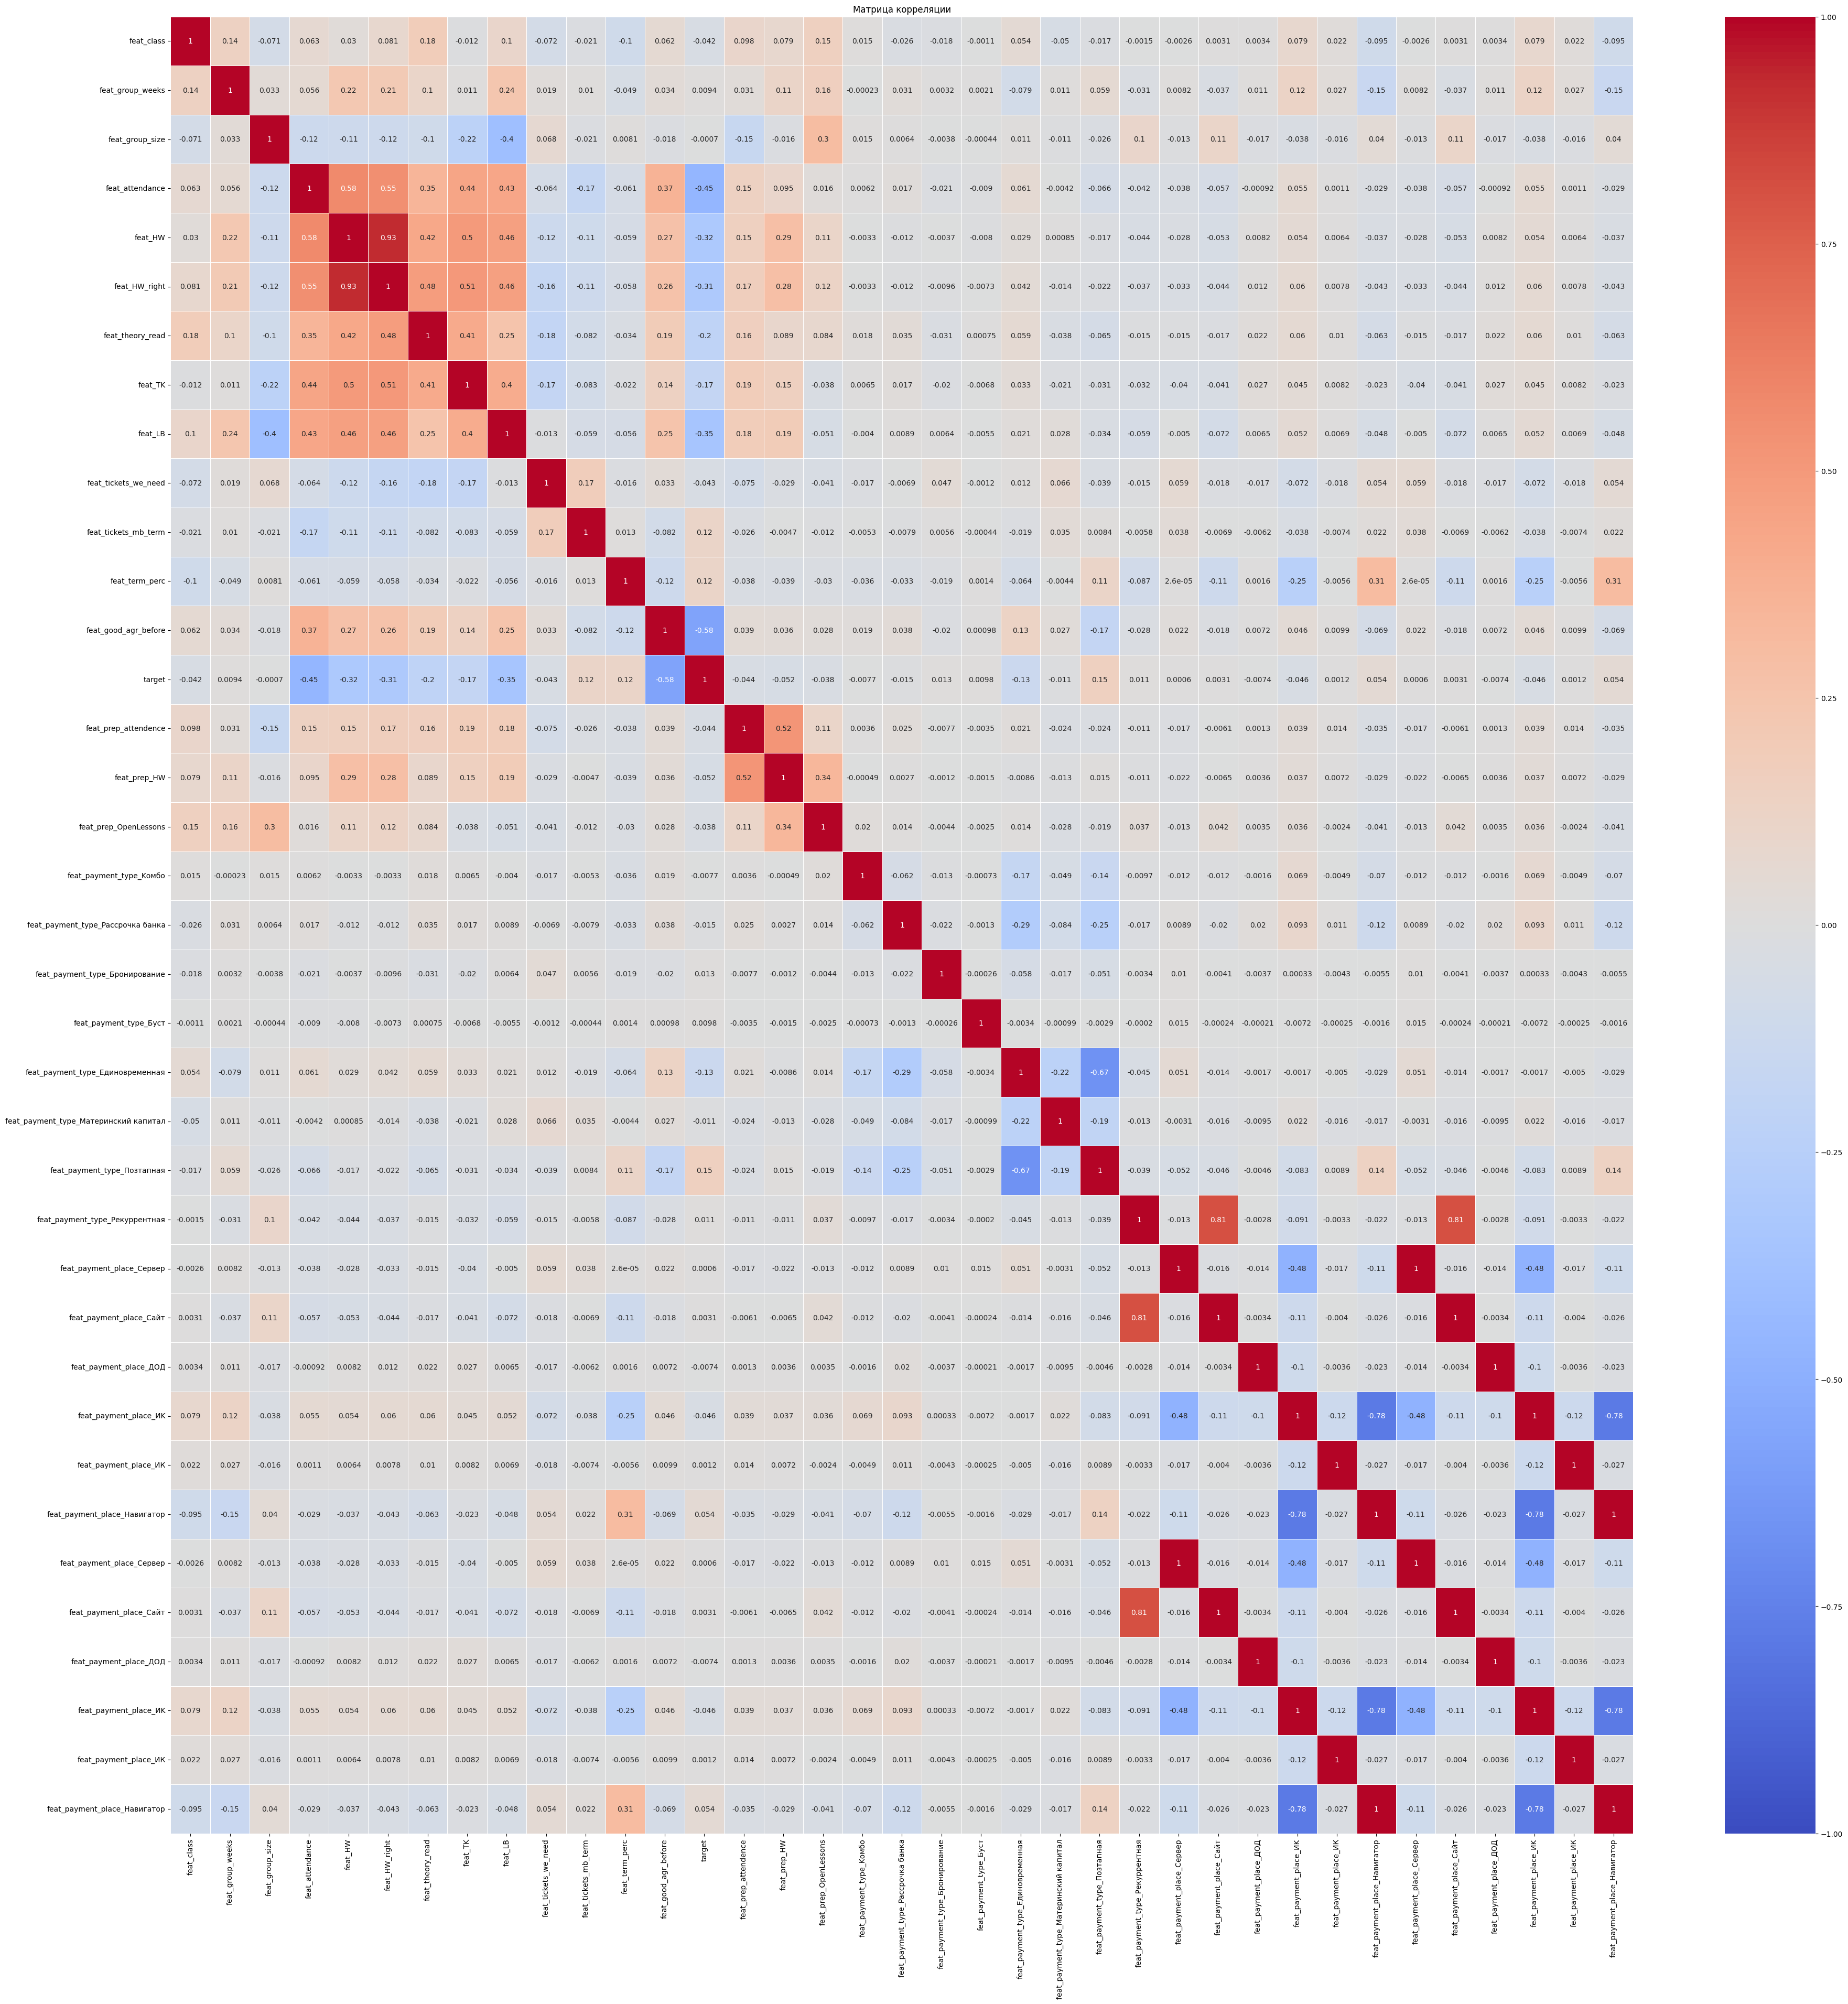

In [33]:
corr_matrix = encoded_ohe_df.corr()
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(45, 45))
sns.heatmap(
    corr_matrix,
    annot=True,  # Показывать значения в ячейках
    cmap='coolwarm',  # Цветовая схема
    vmin=-1, vmax=1,  # Диапазон для шкалы
    linewidths=0.5    # Границы между ячейками
)
plt.title('Матрица корреляции')
plt.show()